MNIST Info-VAE
==

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import clear_output
import sys
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home='.')
print mnist.data.shape


(70000, 784)


In [302]:
def matmul(X, dout, name):
    with tf.variable_scope(name):
        _, dX = X.get_shape()
        W = tf.get_variable('W', shape=(dX, dout))
        b = tf.get_variable('b', initializer=tf.constant(np.zeros(dout).astype(np.float32)))
    return tf.matmul(X, W)+b

def assert_shape(tens, shape):
    assert tens.get_shape().is_compatible_with(shape), '%s does not match expected %s' % (tens.get_shape(), shape)

def relu_layer(X, dout, name):
    return tf.nn.softplus(matmul(X, dout, name))
def tanh_layer(X, dout, name):
    return tf.nn.tanh(matmul(X, dout, name))

def conv_layer(X, num_filters, filter_size, name=None, stride=1):
    _, w, h, ch = X.get_shape()
    with tf.variable_scope(name):
        filters = tf.get_variable('filter', shape=(filter_size[0], filter_size[1], ch, num_filters))
        result = tf.nn.conv2d(X, filters, [1,stride,stride,1], "VALID")
    return result

def spike(x):
    xs = tf.square(x)
    return xs/tf.reduce_sum(xs, reduction_indices=1, keep_dims=True)

def deconv_layer(X, num_filters, filter_size, name, stride=1):
    batch, w, h, ch = X.get_shape()
    w_filt = w*stride+(filter_size[0]-1)
    h_filt = h*stride+(filter_size[1]-1)

    with tf.variable_scope(name):
        Xshape = tf.shape(X)
        output_shape = tf.pack([Xshape[0], int(w_filt), int(h_filt), num_filters])
        
        filters = tf.get_variable('filter', shape=(filter_size[0], filter_size[1], num_filters, ch))
        result = tf.nn.conv2d_transpose(X, filters, output_shape, [1,stride,stride,1], 'VALID')
        result = tf.reshape(result, [-1, int(w_filt), int(h_filt), num_filters])
    return result

def flatten_image(X):
    _, w, h, ch = X.get_shape()
    return tf.reshape(X, [-1, int(w*h*ch)])

class VAE(object):
    def __init__(self, dX, dZ, enc_layers = (128,64), dec_layers=(64,128), lamb=1e-2):
        self.enc_layers = enc_layers
        self.dec_layers = dec_layers
        self.dZ = dZ
        self.dX = dX
        self.lamb = lamb

        self._build_network(dX, dZ)
        self._init_tf()

    def _build_network(self, dX, dZ):

        self.X = X = tf.placeholder(tf.float32, shape=(None, dX), name='X')
        self.noise = tf.placeholder(tf.float32, shape=(None, dZ), name='Z')
        self.lr = tf.placeholder(tf.float32, shape=tuple(), name='lr')

        # Encoding
        mu_enc, log_var_enc, code_mean = self._encode(self.X)
        self.mu = mu_enc
        self.log_var = log_var_enc
        assert_shape(self.mu, [None, self.dZ])
        assert_shape(self.log_var, [None, self.dZ])

        self.var = var_enc = tf.exp(log_var_enc)

        # Decoding
        enc_output = self.noise*tf.sqrt(var_enc) + mu_enc
        assert_shape(enc_output, [None, self.dZ])
        
        # compute max over code
        #code_max = tf.reduce_max(code_mean, reduction_indices=1, keep_dims=True)
        #code_maxed = tf.nn.relu(code_mean - code_max + 1e-5)
        #code_maxed = tf.nn.softmax(code_maxed)
        code_maxed = spike(code_mean)
        
        mu_dec = self._decode(enc_output, code_maxed)
        self.mu_dec = mu_dec
        assert_shape(mu_dec, [None, self.dX])

        # Sample decode
        self.sample_Z = tf.placeholder(tf.float32, shape=(None, dZ), name='Z_sample')
        self.sample_code = tf.placeholder(tf.float32, shape=(None, 10), name='code_sample')
        self.sample_mu = self._decode(self.sample_Z, self.sample_code, reuse=True)
        
        # Code reconstruction error
        mu_enc2, log_var_enc2, code_mean2 = self._encode(self.sample_mu, reuse=True)
        code_err = tf.reduce_sum( self.sample_code*tf.log(1e-6+code_mean2)+
                                 (1-self.sample_code)*tf.log(1e-6+1-code_mean2), reduction_indices=1)
        code_err = self.lamb*tf.reduce_mean(-code_err)
        self.code_step = tf.train.AdamOptimizer(self.lr).minimize(code_err)

        #log_var_enc2_slice = 0.0 #tf.slice(log_var_enc2, [0,0], [-1,self.info_dims])
        #mu_enc2_slice = tf.slice(mu_enc2, [0,0], [-1,self.info_dims])
        #mu_enc_slice = tf.slice(mu_enc, [0,0], [-1,self.info_dims])
        #code_err = tf.reduce_sum(0.5 * log_var_enc2_slice +
        #                                   (tf.square(mu_enc2_slice-mu_enc_slice)/
        #                                    (2.0 * tf.exp(log_var_enc2_slice)))
        #                                   , reduction_indices=1)
        #code_err = tf.reduce_mean(code_err)
        #code_err +=
        #code_err *= self.lamb
            
        # Losses
        logpxz = -tf.reduce_sum(X * tf.log(1e-6 + mu_dec) + (1-X) * tf.log(1e-6 + 1 - mu_dec), reduction_indices=1)
        kldiv = 0.5 * tf.reduce_sum(1 + log_var_enc - tf.square(mu_enc) - tf.exp(log_var_enc), reduction_indices=1)
        self.loss = tf.reduce_mean(logpxz - kldiv + code_err)
        self.stepfn = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
        
    def _encode(self, _X, reuse=False):
        encoding = tf.reshape(_X, [-1, 28, 28, 1])
        with tf.variable_scope('encoder', reuse=reuse):
            encoding = tf.nn.relu(conv_layer(encoding, 4,[4,4], 'conv1', stride=2))
            encoding = tf.nn.relu(conv_layer(encoding, 2,[4,4], 'conv2'))
            encoding = flatten_image(encoding)
            #for i, layer_size in enumerate(self.enc_layers):
            #    encoding = relu_layer(encoding, layer_size, name='enc_%d'%i)
            mu_enc = matmul(encoding, self.dZ, name='enc_mu')
            log_var_enc = matmul(encoding, self.dZ, name='enc_sig')
            code_mean = tf.nn.softmax(matmul(encoding, 10, 'code_cat'))
        return mu_enc, log_var_enc, code_mean
    
    def _decode(self, latent, code, reuse=False):
        output = tf.concat(1, [latent, code])
        with tf.variable_scope('decoder', reuse=reuse):
            #for i, layer_size in enumerate(self.dec_layers):
            #    output = relu_layer(output, layer_size, name='dec_%d'%i)
            fc_size = 11
            output = tf.nn.relu(matmul(output, fc_size**2, name='m1'))
            output = tf.reshape(output, [-1,fc_size,fc_size,1])

            output = tf.nn.relu(deconv_layer(output, 2, [4,4], 'deconv1', stride=2))
            output = tf.nn.relu(deconv_layer(output, 1, [4,4], 'deconv2', stride=1))
            output = tf.reshape(output, [-1,self.dX])
            mu_dec = tf.nn.sigmoid(matmul(output, self.dX, name='dec_mu'))
        return mu_dec

    def _init_tf(self):
        self.sess = tf.Session()
        self.sess.run(tf.initialize_all_variables())

    def step(self, X, lr=0.1):
        batch_size = X.shape[0]
        z = np.random.randn(batch_size, self.dZ)
        
        # generate codes
        indexes = np.random.randint(0,10, size=batch_size)
        categ = np.zeros((batch_size, 10))
        categ[np.arange(batch_size), indexes] = 1
        Z = np.random.randn(batch_size, self.dZ)

        result= self.sess.run([self.loss, self.stepfn, self.code_step],
                feed_dict={ self.X: X, 
                            self.noise:z,
                            self.sample_Z: Z,
                            self.sample_code: categ,
                            self.lr: lr})
        loss = result[0]
        return loss

    def encode(self, X):
        mu, sigma = self.sess.run([self.mu, self.var],
                feed_dict={ self.X: X})
        return mu, sigma
    
    def encode_decode(self, X):
        batch_size = X.shape[0]
        z = np.random.randn(batch_size, self.dZ)
        mu, mu_dec = self.sess.run([self.mu, self.mu_dec],
                          feed_dict={self.X: X, self.noise:z})
        return mu, mu_dec
    
    def decode(self, enc, code):
        enc = np.expand_dims(enc, axis=0)
        categ = np.zeros((1, 10))
        categ[:, code] = 1
        mu_dec = self.sess.run(self.sample_mu, {self.sample_Z: enc, self.sample_code: categ})
        return mu_dec
    
    def sample(self, code, N):
        Z = np.random.randn(N, self.dZ)
        categ = np.zeros((N, 10))
        categ[:, code] = 1

        mu_dec = self.sess.run(self.sample_mu, {self.sample_Z: Z,
                                                self.sample_code: categ})
        return mu_dec
        
        
def mnist_data(batch_size, dataset=mnist.data):
    #dataset = np.array([dataset[1230], dataset[51111], dataset[30000]])
    idx = np.random.randint(low=0, high=len(dataset), size=batch_size)
    return dataset[idx,:]

def spiral_data(batch_size, spiral_rate=1.):
    T = 10
    t = np.random.uniform(size=batch_size, low=0, high=T)
    x = t*np.cos(t*spiral_rate)/T
    y = t*np.sin(t*spiral_rate)/T
    data = np.array([x,y]).T
    noise = np.random.randn(batch_size,2)/(T*2)
    return data+noise

Training & Test
===

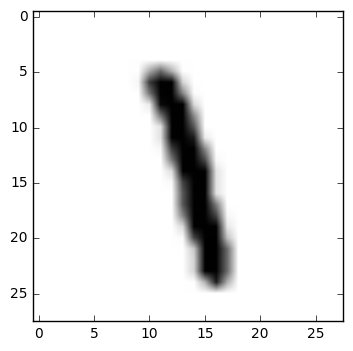

In [303]:
sample_distribution = lambda x: mnist_data(x)/255.
example = sample_distribution(1)[0]
example = np.reshape(example, [28,28])
plt.imshow(example, cmap='Greys')
plt.show()

In [304]:
#Training
tf.reset_default_graph()
np.random.seed(2)
dX = sample_distribution(1).shape[1]
dZ = 2
info_dims = 2
batch_size = 32
vae = VAE(dX, dZ, enc_layers=[512,512], dec_layers=[512,512], lamb=100.,)

tot_loss = 0
heartbeat = 400
losses = []
for i in range(4000):
    x = sample_distribution(batch_size)
    loss = vae.step(x, lr=2e-3)
    tot_loss += loss
    if i%heartbeat == 0 and i>0:
        #clear_output()
        print i, tot_loss/heartbeat
        losses.append(tot_loss/heartbeat)
        sys.stdout.flush()
        tot_loss = 0
        #mus, sigmas = vae.encode(x)
        #print np.mean(mus, axis=1)
        #print np.mean(sigmas, axis=1)

400 218.229634361
800 157.029378128
1200 151.753904305
1600 149.814269733
2000 174.325306129
2400 151.572882919
2800 147.070218983
3200 145.467591991
3600 143.778743057


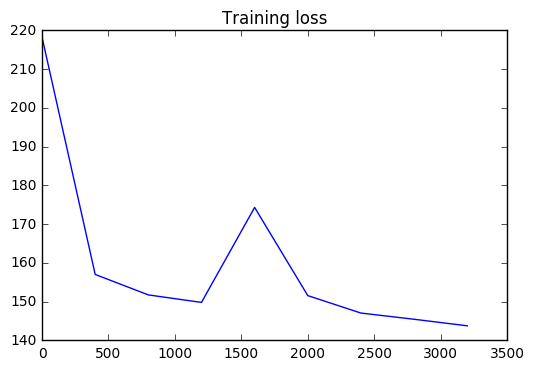

In [305]:
# Training plot
plt.title("Training loss")
plt.plot(np.arange(len(losses))*heartbeat, losses)
plt.show()

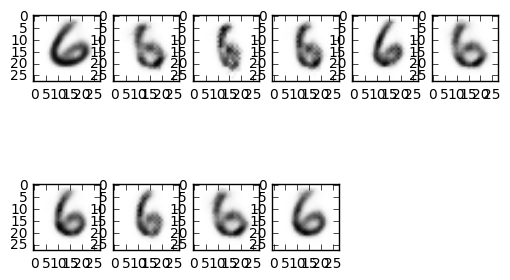

In [306]:
# Try sampling!
np.set_printoptions(suppress=True)
samples = vae.sample(6, 10)

rows = 2
cols = len(samples)/2 +1
plt.figure()
for i, samp in enumerate(samples):
    plt.subplot(rows, cols, i+1)
    example = np.reshape(samp, [28,28])
    #print example
    plt.imshow(example, cmap='Greys')
plt.show()


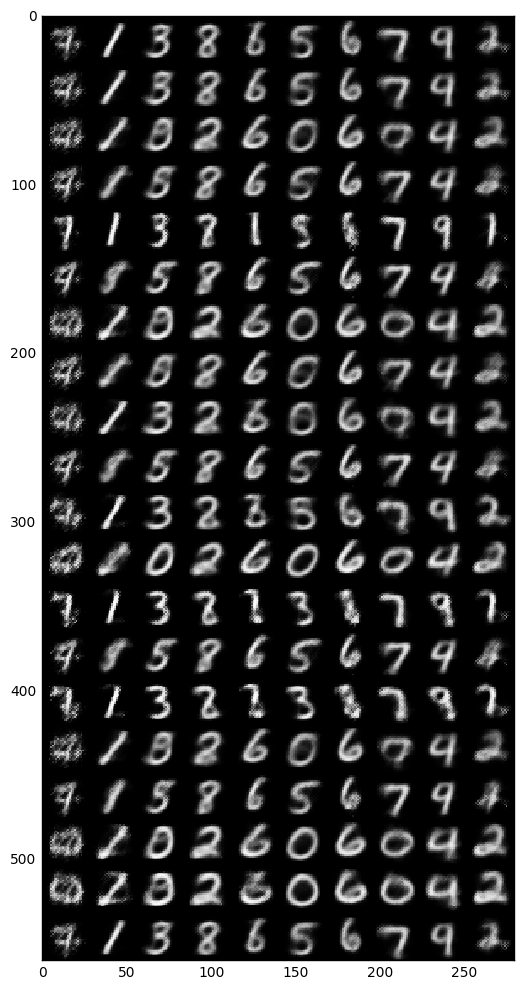

In [309]:
nx = 20
x_values = np.linspace(-3, 3, nx)
canvas = np.empty((nx*28, 10*28))

non_info_dims = np.random.randn(dZ-info_dims)
for i, yi in enumerate(x_values):
    z_mu = np.random.randn(vae.dZ)
    for j, code in enumerate(range(10)):
        x_mean = vae.decode(z_mu, j)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
plt.tight_layout()

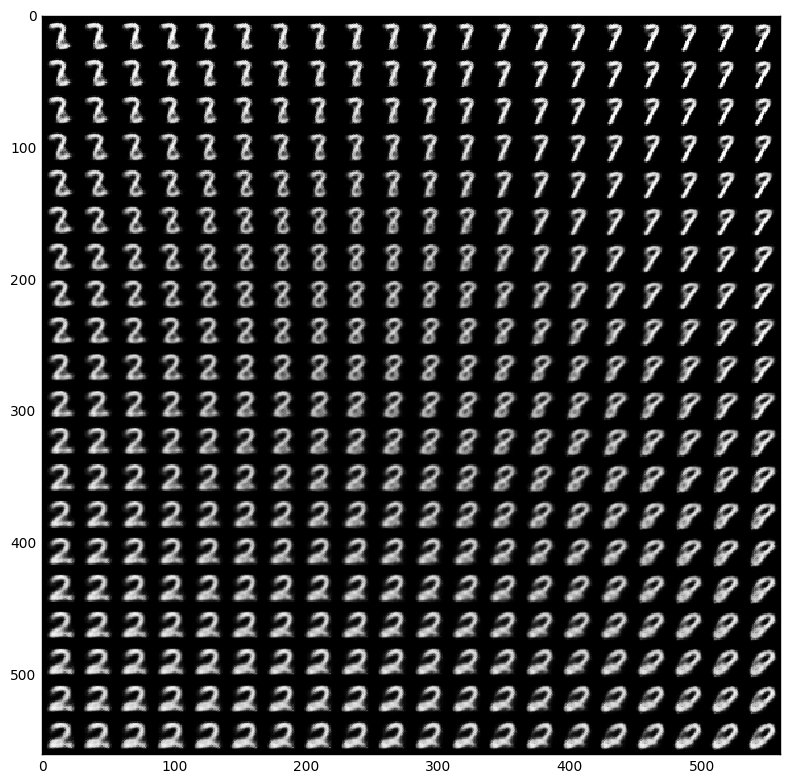

In [308]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
canvas = np.empty((28*ny, 28*nx))

non_info_dims = np.random.randn(dZ-info_dims)
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.concatenate([np.array([xi, yi])])
        x_mean = vae.decode(z_mu, 3)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
plt.tight_layout()

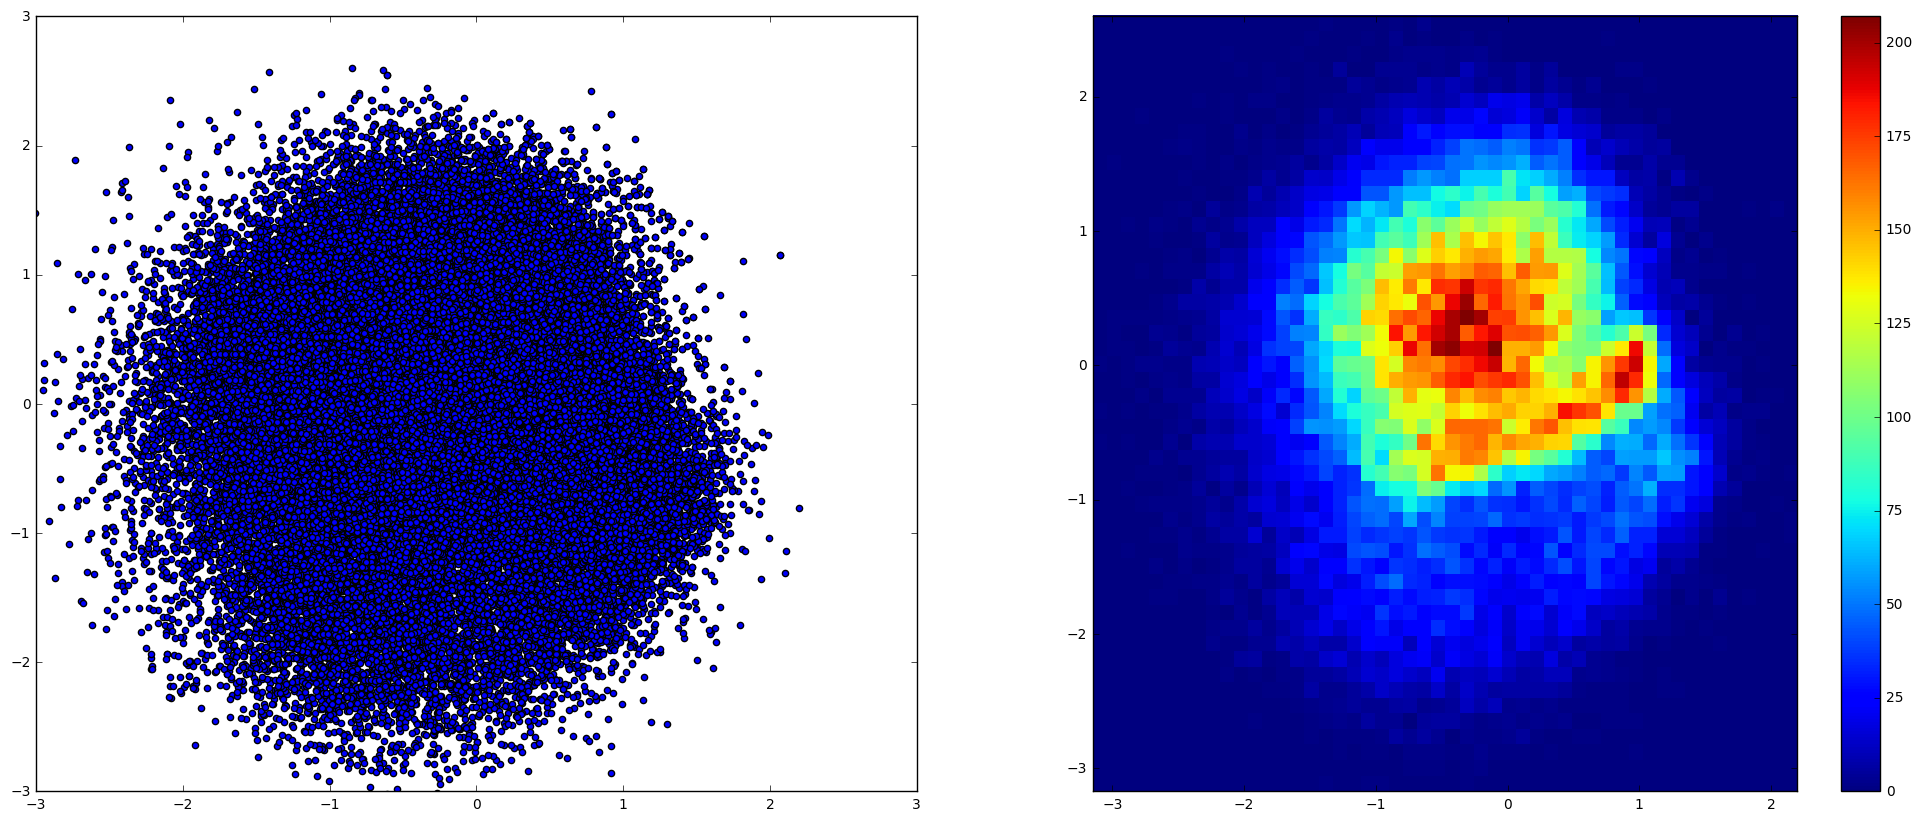

In [213]:
all_z, all_z_sig = vae.encode(mnist.data/255.) 
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.scatter(all_z[:,0], all_z[:,1])
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.subplot(1,2,2)
plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
plt.colorbar()
plt.show()